In [ ]:
!pip install d2l==0.14

通过多项式拟合来交互地探索这些概念

In [2]:
import torch
from torch import nn
from d2l import torch as d2l
import math
import numpy as np

首先，我们需要数据。给定 x ，我们将使用以下三阶多项式来生成训练和测试数据的标签：

(4.4.2)¶
y=5+1.2x−3.4x22!+5.6x33!+ϵ where ϵ∼N(0,0.12).
 
噪声项 ϵ 服从均值为0且标准差为0.1的正态分布。在优化的过程中，我们通常希望避免非常大的梯度值或损失值。这就是我们将特征从 xi 调整为 xii! 的原因，这样可以避免很大的 i 带来的特别大的指数值。我们将为训练集和测试集各生成100个样本。

In [5]:
max_degree=20
n_train,n_test=100,100
true_w=np.zeros(max_degree)
true_w[0:4]=np.array([5,1.2,-3.4,5.6])

features=np.random.normal(size=(n_train+n_test,1))
np.random.shuffle(features)
poly_features=np.power(features,np.arange(max_degree).reshape(1,-1))
for i in range(max_degree):
  poly_features[:,i]/=math.gamma(i+1)
labels=np.dot(poly_features,true_w)
labels+=np.random.normal(scale=0.1,size=labels.shape)

前2维数据

In [6]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.7940],
         [-0.4042]]),
 tensor([[ 1.0000e+00, -7.9397e-01,  3.1519e-01, -8.3417e-02,  1.6558e-02,
          -2.6292e-03,  3.4792e-04, -3.9462e-05,  3.9164e-06, -3.4550e-07,
           2.7432e-08, -1.9800e-09,  1.3100e-10, -8.0009e-12,  4.5375e-13,
          -2.4017e-14,  1.1918e-15, -5.5662e-17,  2.4552e-18, -1.0260e-19],
         [ 1.0000e+00, -4.0421e-01,  8.1691e-02, -1.1007e-02,  1.1122e-03,
          -8.9915e-05,  6.0573e-06, -3.4977e-07,  1.7673e-08, -7.9371e-10,
           3.2082e-11, -1.1789e-12,  3.9709e-14, -1.2347e-15,  3.5647e-17,
          -9.6059e-19,  2.4267e-20, -5.7700e-22,  1.2957e-23, -2.7565e-25]]),
 tensor([2.5271, 4.2028]))

实现一个函数来评估模型在给定数据集上的损失

In [10]:
def evaluate_loss(net,data_iter,loss):
  """评估给定数据集上模型的损失"""
  metric=d2l.Accumulator(2)
  for X,y in data_iter:
    out=net(X)
    y=y.reshape(out.shape)
    l=loss(out,y)
    metric.add(l.sum(),l.numel())
  return metric[0]/metric[1]

定义训练模型

In [8]:
def train(train_features,test_features,train_labels,test_labels,num_epochs=400):
  loss=nn.MSELoss()
  input_shape=train_features.shape[-1]
  net=nn.Sequential(nn.Linear(input_shape,1,bias=False))
  batch_size=min(10,train_labels.shape[0])
  train_iter=d2l.load_array((train_features,train_labels.reshape(-1,1)),batch_size)
  test_iter=d2l.load_array((test_features,test_labels.reshape(-1,1)),batch_size,is_train=False)
  trainer=torch.optim.SGD(net.parameters(),lr=0.01)
  animator=d2l.Animator(xlabel='epoch',ylabel='loss',yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
  for epoch in range(num_epochs):
    d2l.train_epoch_ch3(net,train_iter,loss,trainer)
    if epoch==0 or (epoch+1)%20==0:
      animator.add(epoch+1,(evaluate_loss(net,train_iter,loss),evaluate_loss(net,test_iter,loss)))
    print('weight:',net[0].weight.data.numpy())

三阶多项式函数拟合（正态）

weight: [[ 4.9925327  1.25197   -3.4014919  5.5268607]]


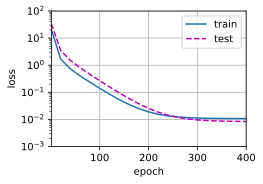

In [11]:
train(poly_features[:n_train,:4],poly_features[n_train:,:4],labels[:n_train],labels[n_train:])

线性函数拟合（欠拟合）

weight: [[3.4840782 3.6750228]]


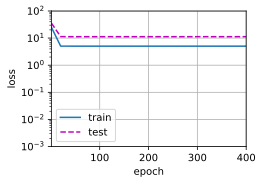

In [12]:
train(poly_features[:n_train,:2],poly_features[n_train:,:2],labels[:n_train],labels[n_train:])

高阶多项式函数拟合（过拟合）

weight: [[ 5.0008793   1.3728453  -3.4061358   4.9183626  -0.19938484  1.6460147
   0.22919506  0.25433308 -0.05061154  0.03880899  0.11302377  0.16243501
   0.16715673 -0.08809581  0.19550443  0.07610106 -0.221813    0.14074835
   0.02120016  0.07520465]]


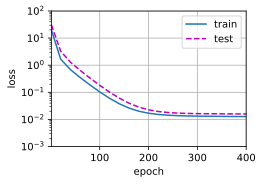

In [15]:
train(poly_features[:n_train,:],poly_features[n_train:,:],labels[:n_train],labels[n_train:])